<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/03-ml-housing-prediction/RealEstateAI_PricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealEstateAI Solutions - predictive model for real estate pricing

> 👨‍💻 Developed as part of the **AI Engineering Master – Week 2**

This project aims to build a predictive model for real estate pricing using linear regression techniques with regularization. The objective is to improve model generalization, reduce overfitting, and offer robust, accurate pricing estimates using Ridge, Lasso, and Elastic Net regressions.

## Key Goals:
- Load and preprocess the housing dataset
- Handle missing values and categorical variables
- Scale features for regularization methods
- Train Ridge, Lasso, and Elastic Net models
- Evaluate models using Cross-Validation and MSE
- Compare performance and model sparsity
- Visualize results and residuals

🔗 GitHub Repository:
[📁 ai-portfolio]()


---



## Load & Explore Dataset

- Load the housing data from the provided URL
- Display dataset info and initial rows

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import kagglehub
import pandas as pd
import numpy as np

from kagglehub import KaggleDatasetAdapter

In [3]:
# Set the path to the file you'd like to load
file_path = 'Housing.csv'

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  'yasserh/housing-prices-dataset',
  file_path,
)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [6]:
# Checking for unique values in categorical variables
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f'{col}: {df[col].unique()}')

mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


In [7]:
# Checking for unbalanced distribution of binary variables
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

for col in binary_cols:
  print(f'{df[col].value_counts()}')

mainroad
yes    468
no      77
Name: count, dtype: int64
guestroom
no     448
yes     97
Name: count, dtype: int64
basement
no     354
yes    191
Name: count, dtype: int64
hotwaterheating
no     520
yes     25
Name: count, dtype: int64
airconditioning
no     373
yes    172
Name: count, dtype: int64
prefarea
no     417
yes    128
Name: count, dtype: int64


## 📊 Useful Information

- The dataset contains **545 rows** and **13 columns**
- The dataset includes two main data types: `int64` for numerical features and `object` for categorical ones
- No missing values are present in any column (`df.isna().sum() == 0`)
- All categorical variables are clean and consistent (`yes`/`no`, `furnished` variants)
- > Although some binary features (e.g. `hotwaterheating`) are imbalanced, this is not a concern in linear regression. The model estimates the best-fitting coefficient for each feature based on MSE minimization, regardless of class balance. If a feature is irrelevant or noisy, Lasso/ElasticNet will naturally shrink or remove it.


---




# 🧹 Data Preprocessing

- Encode categorical variables (e.g. Furnishingstatus)
- Standardize the features using StandardScaler
- Split into features (X) and target (y)




In [8]:
# saving the categorical columns lables
categorical_cols_lables = categorical_cols.to_list()
categorical_cols_lables.remove('furnishingstatus')

In [9]:
yes_no_map = {
    'yes': 1,
    'no': 0
}

for col_label in categorical_cols_lables:
  df[col_label] = df[col_label].map(yes_no_map)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished


In [10]:
ordinal_map = {
    'unfurnished': 0,
    'semi-furnished': 1,
    'furnished': 2
}
df['furnishingstatus'] = df['furnishingstatus'].map(ordinal_map)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2


## Showing correlation matrix
This is done for:
- Having an idea of feature–target correlations
- Detecting collinearity informs our regularization strategy and helps ensure stable, interpretable models.

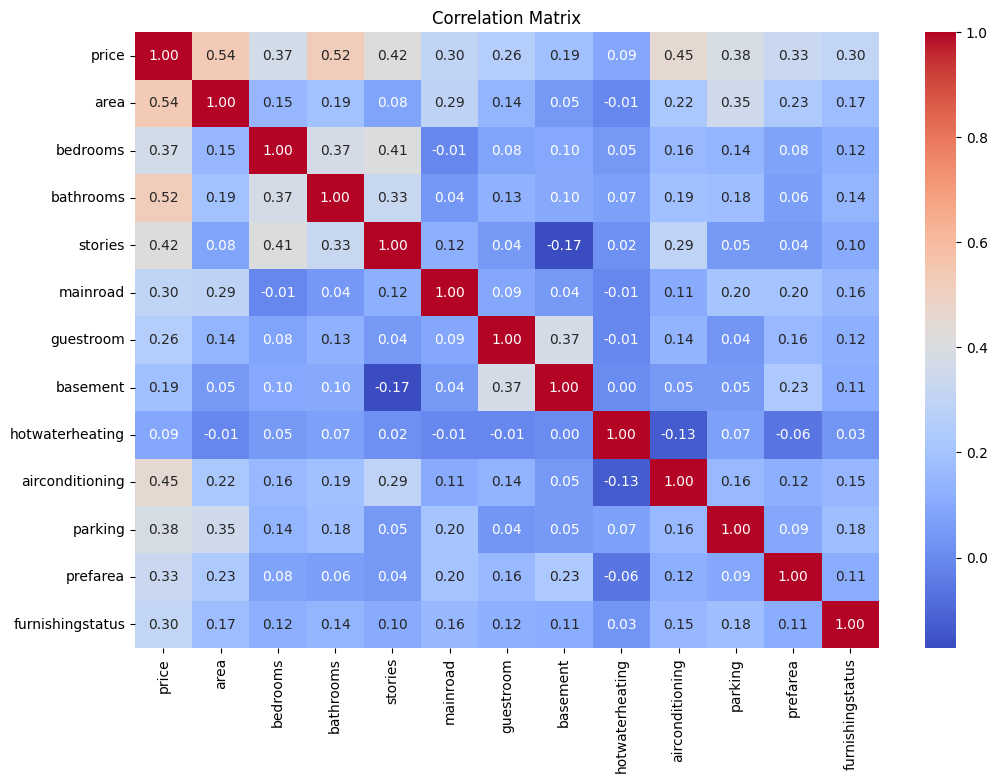

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Correlation Matrix Results

- **No feature** shows a strong correlation (>|0.7|).  
- The heatmap reveals **no problematic collinearity** between features.  
- Correlation values in the **0.3–0.4** range may indicate slight relationships, but are **not** strong enough to cause serious multicollinearity issues.

### Key Correlations with `price`
- **Area:** 0.54  
- **Bathrooms:** 0.52  
- **Airconditioning:** 0.45


---



### Feature Scaling

Next step is to standardizing the numerical features using `StandardScaler`. This is important because regularized linear models such as Ridge, Lasso, and ElasticNet are sensitive to the scale of the input features.

This ensures that all features contribute equally to the regularization term and prevents features with larger numeric ranges from dominating the model.


In [12]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
#    - test_size=0.2 reserves 20% of the data for evaluation
#    - random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training features
#    - learns the mean and standard deviation from X_train
#    - prevents information leakage from the test set
scaler.fit(X_train)

# Apply the learned transformation to both sets
#    - center to mean=0 and scale to unit variance
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

X_train_scaled_df.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
46,0.384168,0.055271,1.539173,2.587644,0.407155,-0.466773,-0.746420,-0.230521,1.501243,0.367957,-0.55262,1.409401
93,0.929181,0.055271,1.539173,-0.912499,0.407155,-0.466773,1.339728,-0.230521,1.501243,2.709987,-0.55262,0.079317
